# **STEP 0: SETUP**

In [1]:
# STEP 0: Setup and Imports
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import hashlib
from collections import defaultdict
import random
from pathlib import Path

AUTOTUNE = tf.data.AUTOTUNE


0.1 Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0.11 Flatten Directory Structure

DO THIS ONLY IF DIRECTORY IS NOT FLAT!

In [2]:
import os
import shutil
from pathlib import Path

def flatten_directory(root):
    root_path = Path(root)
    for crop_folder in root_path.iterdir():
        if crop_folder.is_dir():
            for disease_folder in crop_folder.iterdir():
                if disease_folder.is_dir():
                    dest = root_path / disease_folder.name
                    if not dest.exists():
                        shutil.move(str(disease_folder), str(dest))
                    else:
                        # Merge if destination already exists
                        for f in disease_folder.iterdir():
                            shutil.move(str(f), str(dest / f.name))
                        shutil.rmtree(disease_folder)
            shutil.rmtree(crop_folder)

# Apply to train, val, and test
flatten_directory('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/train')
flatten_directory('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/val')
flatten_directory('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/test')


0.2 Display contents of Data Drive

In [3]:
import os

data_dir = '/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/'

for crop in os.listdir(data_dir):
    crop_path = os.path.join(data_dir, crop)
    if os.path.isdir(crop_path):
        print(f"{crop}:")
        subfolders = os.listdir(crop_path)
        print(f"  {subfolders}\n")

test:
  ['Potato___Healthy', 'Potato___Early_Blight', 'Rice___Brown_Spot', 'Potato___Late_Blight', 'Corn___Gray_Leaf_Spot', 'Corn___Northern_Leaf_Blight', 'Corn___Healthy', 'Corn___Common_Rust', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Yellow_Rust', 'Wheat___Healthy', 'Wheat___Brown_Rust']

train:
  ['Corn___Northern_Leaf_Blight', 'Corn___Healthy', 'Corn___Gray_Leaf_Spot', 'Corn___Common_Rust', 'Rice___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Leaf_Blast', 'Wheat___Brown_Rust', 'Potato___Healthy', 'Potato___Early_Blight', 'Rice___Neck_Blast', 'Wheat___Yellow_Rust', 'Wheat___Healthy']

val:
  ['Corn___Healthy', 'Potato___Healthy', 'Corn___Gray_Leaf_Spot', 'Corn___Northern_Leaf_Blight', 'Corn___Common_Rust', 'Potato___Early_Blight', 'Potato___Late_Blight', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Yellow_Rust', 'Wheat___Brown_Rust', 'Rice___Brown_Spot', 'Wheat___Healthy', 'Rice___Healthy']



0.3 Display till image level

In [ ]:
import os

data_dir = '/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/'

# Traverse crops
for crop in os.listdir(data_dir):
    crop_path = os.path.join(data_dir, crop)
    if os.path.isdir(crop_path):
        print(f"{crop}/")  # Crop level

        # Traverse subfolders (conditions)
        for condition in os.listdir(crop_path):
            condition_path = os.path.join(crop_path, condition)
            if os.path.isdir(condition_path):
                print(f"  {condition}/")  # Condition level

                # Traverse image files
                for image_file in os.listdir(condition_path):
                    image_path = os.path.join(condition_path, image_file)
                    if os.path.isfile(image_path):
                        print(f"    {image_file}")  # Image file level

        print()  # Add space between crops

# ** STEP 1: DATA PREPROCESSING**

1.1 Find Duplicate Images

In [7]:
# STEP 1.1: Find duplicate images using MD5 hash
from pathlib import Path

def find_duplicates(directory):
    hashes = {}
    duplicates = []
    for img_path in Path(directory).rglob('*.[pjPJ]*[npNP]*[gG]'):  # jpg/jpeg/png
        try:
            with open(img_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicates.append((img_path, hashes[file_hash]))
            else:
                hashes[file_hash] = img_path
        except:
            pass
    return duplicates

dupes = find_duplicates('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/')
print(f"Found {len(dupes)} duplicate images.")
for d in dupes[:5]: print(d)


Found 0 duplicate images.


1.2 Find Empty Images & Confirm Class Image Counts

In [8]:
# STEP 1.2: Detect empty images or those with 0 dimensions
def find_empty_images(directory):
    empty_images = []
    for img_path in Path(directory).rglob("*.*"):
        try:
            img = Image.open(img_path)
            if img.size == (0, 0):
                empty_images.append(img_path)
        except UnidentifiedImageError:
            empty_images.append(img_path)
    return empty_images

empties = find_empty_images('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/')
print(f"Found {len(empties)} empty or unreadable images.")
for e in empties[:5]: print(e)


Found 0 empty or unreadable images.


1.3 Verify Valid File Formats

In [11]:
# STEP 1.3: Check for valid image formats
valid_extensions = ['.jpg', '.jpeg', '.png','.gif','.tiff']
bad_formats = [p for p in Path('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/').rglob("*.*") if p.suffix.lower() not in valid_extensions]
print(f"Found {len(bad_formats)} invalid format images.")


Found 0 invalid format images.


1.4 Detect Corrupted Images

In [9]:
# STEP 1.4: Try to open and verify all images
def find_corrupted_images(directory):
    corrupted = []
    for img_path in Path(directory).rglob("*.*"):
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception:
            corrupted.append(img_path)
    return corrupted

corrupted = find_corrupted_images('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/')
print(f"Found {len(corrupted)} corrupted images.")


Found 0 corrupted images.


1.5 Check for Class Imbalance & Plot Distribution

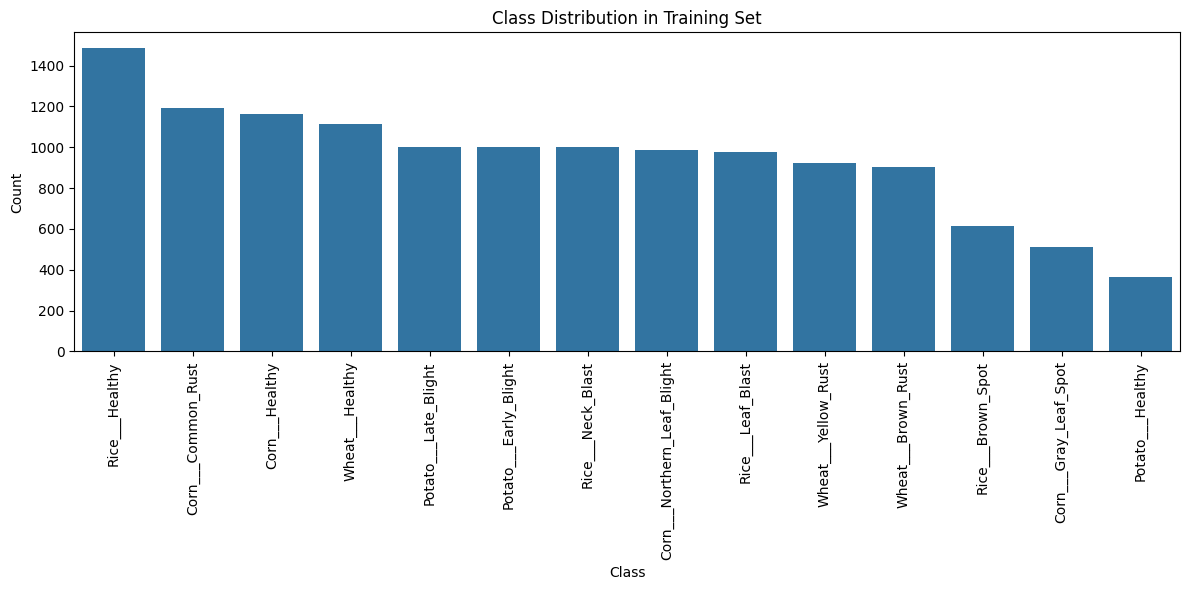

In [12]:
# STEP 1.5 & 1.6: Class balance and distribution plot
from collections import Counter
valid_extensions = ['.jpg', '.jpeg', '.png','.gif','.tiff']

def count_classes(directory):
    class_counts = defaultdict(int)
    for path in Path(directory).rglob("*.*"):
        if path.suffix.lower() in valid_extensions:
            class_name = path.parent.name
            class_counts[class_name] += 1
    return class_counts

train_counts = count_classes('/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/')
df_counts = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_counts.sort_values(by='Count', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x='Class', y='Count')
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()


# STEP 2: CNN **PIPELINE**

2.1 Load, Augment, Normalize with Prefetch

In [4]:
# STEP 2.1: Load Datasets
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     '/content/drive/MyDrive/SDS/SmartLeaf/CropDiseaseSplit/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
with open("class_names.txt", "w") as f:
    f.writelines("\n".join(class_names))
print(train_ds.class_names)

# Augment + Normalize
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


Found 9323 files belonging to 14 classes.
Found 2600 files belonging to 14 classes.
Found 1312 files belonging to 14 classes.
['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


2.2 Define CNN Model

In [5]:
# STEP 2.2: CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,248,270 (84.87 MB)

 Trainable params: 22,248,270 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

 2.3 Compile the Model

In [6]:
# STEP 2.3: Compile Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


2.4 Callbacks Setup

In [7]:
# STEP 2.4: Define Callbacks
checkpoint_path = "/content/drive/MyDrive/SDS/SmartLeaf/best_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
]


2.5 Train the Model

In [8]:
# STEP 2.5: Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4852 - loss: 1.5751
Epoch 1: val_loss improved from inf to 0.80791, saving model to /content/drive/MyDrive/SDS/SmartLeaf/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1994s 2s/step - accuracy: 0.4857 - loss: 1.5733 - val_accuracy: 0.7535 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 2/15
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7780 - loss: 0.5713
Epoch 2: val_loss improved from 0.80791 to 0.38607, saving model to /content/drive/MyDrive/SDS/SmartLeaf/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 204s 432ms/step - accuracy: 0.7780 - loss: 0.5712 - val_accuracy: 0.8423 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 3/15
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7951 - loss: 0.5097
Epoch 3: val_loss did not improve from 0.38607
292/292 ━━━━━━━━━━━━━━━━━━━━ 200s 389ms/step - accuracy: 0.7951 - loss: 0.5096 - val_accuracy: 0.7908 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 4/15
292/2

2.6 Plot Training Curves

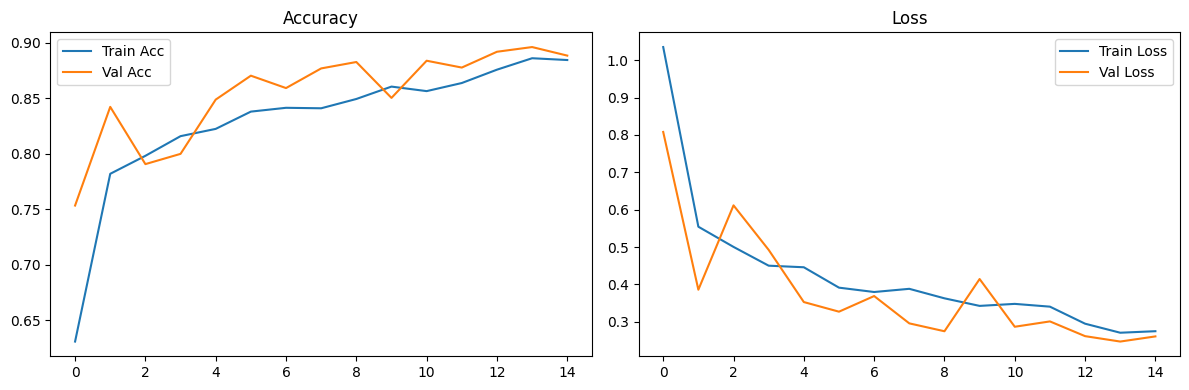

In [9]:
# STEP 2.6: Plot Training Curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()


2.7 Evaluate Model against Test DS & Generate  Confusion Matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.8841 - loss: 0.2716
Test Accuracy: 90.17%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━

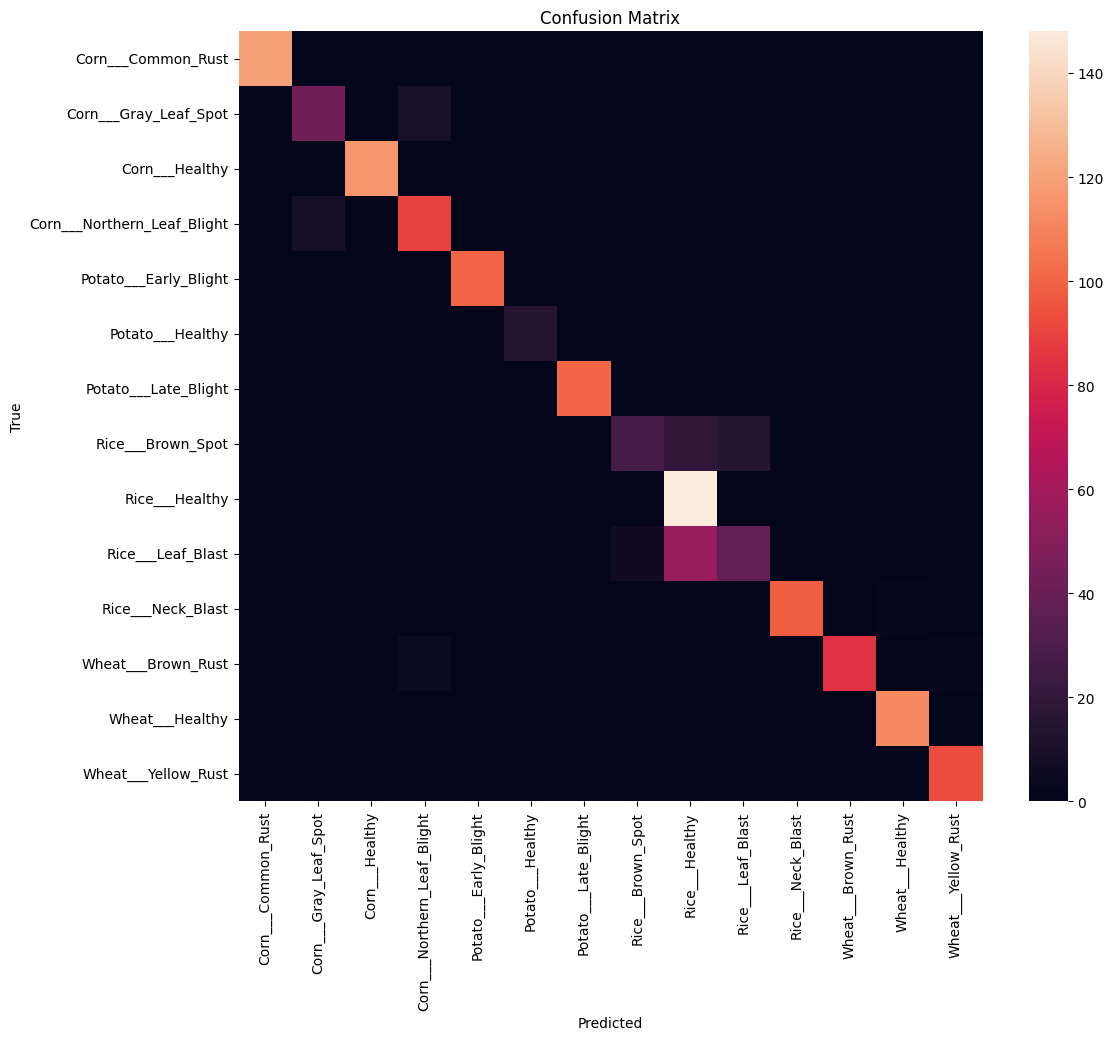

                             precision    recall  f1-score   support

         Corn___Common_Rust       1.00      1.00      1.00       120
      Corn___Gray_Leaf_Spot       0.83      0.83      0.83        52
             Corn___Healthy       1.00      0.99      1.00       117
Corn___Northern_Leaf_Blight       0.87      0.91      0.89        99
      Potato___Early_Blight       1.00      1.00      1.00       100
           Potato___Healthy       1.00      0.94      0.97        16
       Potato___Late_Blight       0.99      1.00      1.00       100
          Rice___Brown_Spot       0.79      0.44      0.56        62
             Rice___Healthy       0.66      0.99      0.79       150
          Rice___Leaf_Blast       0.69      0.37      0.48        99
          Rice___Neck_Blast       0.99      0.98      0.98       100
         Wheat___Brown_Rust       0.98      0.92      0.95        91
            Wheat___Healthy       0.98      1.00      0.99       112
        Wheat___Yellow_Rust      

In [10]:
# STEP 2.7: Evaluate on Test Set
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


2.8 Load & Evaluate Saved Model

In [11]:
# STEP 2.8: Load Best Model
best_model = tf.keras.models.load_model(checkpoint_path)
loss, acc = best_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {acc*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.8879 - loss: 0.2801
Loaded model test accuracy: 90.17%


# **Streamlit App**

In [12]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [13]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Load saved class names
with open("class_names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# Load best model
model = tf.keras.models.load_model("/content/drive/MyDrive/SDS/SmartLeaf/best_model.keras")

# Preprocess input image
def preprocess_image(image):
    image = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    return img_array / 255.0

# UI
st.set_page_config(page_title="Crop Disease Classifier", layout="centered")
st.title("🌿 Crop Disease Detection")
st.markdown("Upload a leaf image to classify the **crop type** and **disease**.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg",".gif",".tiff"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)
    st.write("Processing...")
    img = preprocess_image(image)
    predictions = model.predict(img)
    score = tf.nn.softmax(predictions[0])
    st.success(f"Predicted: **{class_names[np.argmax(score)]}** with **{100 * np.max(score):.2f}%** confidence")


2025-05-30 18:53:23.679 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 18:53:23.681 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 18:53:25.067 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-30 18:53:25.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 18:53:25.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 18:53:25.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 18:53:25.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [14]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.241.130:8501

  Stopping...
^C
